In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l4_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l4_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1538
0
26 36 (1, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1534/1538 [============================>.] - ETA: 0s - loss: 8.4628 - total_loss: 8.4628 - reg_loss: 8.4628Epoch 00001: saving model to testlstm_l4_4/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1538/1538 [==============================] - 20s 13ms/step - loss: 8.4633 - total_loss: 8.4633 - reg_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927795  0.001315  0.227468    7  2017-04-16
472     2.507290  2.521748 -0.014458  0.227745    1  2017-04-17
473     2.661330  2.673758 -0.012428  0.245677    2  2017-04-18
474     2.754815  2.781391 -0.026577  0.205421    3  2017-04-19
475     2.713762  2.728008 -0.014246  0.233565    4  2017-04-20
476     2.999000  2.998683  0.000317  0.152833    5  2017-04-21
477     3.075529  3.086086 -0.010557  0.184368    6  2017-04-22

0.211010932719
best_epochs [5, 4, 9, 10, 6]
(829, 1) 2.67319954874 

2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196718, 2) (48285, 2)
train/valid # (196718, 2) (48285, 2)
rand split across time
train has 196718 records out of 372221 records
valid has 48285 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1536
0
26 36 (2, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1536/1536 [==============================] - 19s 13ms/step - loss: 0.2919 - total_loss: 0.2919 - reg_loss: 0.2919 - val_loss: 0.2546 - val_total_loss: 0.2546 - val_reg_loss: 0.2546
Epoch 2/100
1536/1536 [==============================] - 19s 12ms/step

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.952781 -0.023671  0.236119    6  2017-04-15
471     2.507290  2.543251 -0.035961  0.232662    7  2017-04-16
472     2.661330  2.680216 -0.018886  0.251854    1  2017-04-17
473     2.754815  2.784380 -0.029565  0.214936    2  2017-04-18
474     2.713762  2.736369 -0.022607  0.238513    3  2017-04-19
475     2.999000  3.007494 -0.008494  0.155573    4  2017-04-20
476     3.075529  3.088296 -0.012767  0.185017    5  2017-04-21

0.216382246803
best_epochs [7, 4, 2, 9, 1]
(829, 1) 2.51437549842 

3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196544, 2) (48244, 2)
train/valid # (196544, 2) (48244, 2)
rand split across time
train has 196544 records out of 372221 records
valid has 48244 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1535
0
26 36 (3, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1531/1535 [============================>.] - ETA: 0s - loss: 8.4601 - total_loss: 8.4601 - reg_loss: 8.4601Epoch 00001: saving model to testlstm_l4_4/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1535/1535 [=============================

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.920709  0.008401  0.238118    5  2017-04-14
470     2.507290  2.513383 -0.006093  0.236337    6  2017-04-15
471     2.661330  2.665486 -0.004156  0.262653    7  2017-04-16
472     2.754815  2.758070 -0.003255  0.219372    1  2017-04-17
473     2.713762  2.727538 -0.013776  0.240208    2  2017-04-18
474     2.999000  3.012980 -0.013980  0.158677    3  2017-04-19
475     3.075529  3.096096 -0.020566  0.189604    4  2017-04-20

0.220709754967
best_epochs [5, 4, 6, 7, 1]
(829, 1) 2.64916278097 

4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196354, 2) (48204, 2)
train/valid # (196354, 2) (48204, 2)
rand split across time
train has 196354 records out of 372221 records
valid has 48204 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1534
0
26 36 (4, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1534/1534 [==============================] - 19s 13ms/step - loss: 0.2937 - total_loss: 0.2937 - reg_loss: 0.2937 - val_loss: 0.2647 - val_total_loss: 0.2647 - val_reg_loss: 0.2647
Epoch 2/100
1534/1534 [==============================] - 19s 12ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.918400  0.010710  0.245118    4  2017-04-13
469     2.507290  2.523839 -0.016549  0.237389    5  2017-04-14
470     2.661330  2.664971 -0.003641  0.259730    6  2017-04-15
471     2.754815  2.734847  0.019968  0.219197    7  2017-04-16
472     2.713762  2.727614 -0.013852  0.244740    1  2017-04-17
473     2.999000  2.995908  0.003092  0.164657    2  2017-04-18
474     3.075529  3.070950  0.004579  0.186937    3  2017-04-19

0.222538273715
best_epochs [5, 6, 4, 3, 7]
(829, 1) 2.69727331653 

5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196139, 2) (48148, 2)
train/valid # (196139, 2) (48148, 2)
rand split across time
train has 196139 records out of 372221 records
valid has 48148 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1532
0
26 36 (5, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1532/1532 [==============================] - 21s 14ms/step - loss: 0.2905 - total_loss: 0.2905 - reg_loss: 0.2905 - val_loss: 0.2603 - val_total_loss: 0.2603 - val_reg_loss: 0.2603
Epoch 2/100
1532/1532 [==============================] - 21s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.932944 -0.003834  0.238819    3  2017-04-12
468     2.507290  2.522796 -0.015506  0.242357    4  2017-04-13
469     2.661330  2.671325 -0.009995  0.262799    5  2017-04-14
470     2.754815  2.779859 -0.025044  0.216708    6  2017-04-15
471     2.713762  2.763266 -0.049504  0.250670    7  2017-04-16
472     2.999000  3.006472 -0.007473  0.167832    1  2017-04-17
473     3.075529  3.115320 -0.039791  0.189637    2  2017-04-18

0.224117643331
best_epochs [4, 5, 6, 7, 2]
(829, 1) 2.75346821295 

6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 15.1334
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195924, 2) (48095, 2)
train/valid # (195924, 2) (48095, 2)
rand split across time
train has 195924 records out of 372221 records
valid has 48095 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1530
0
26 36 (6, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1530/1530 [==============================] - 20s 13ms/step - loss: 0.2958 - total_loss: 0.2958 - reg_loss: 0.2958 - val_loss: 0.2646 - val_total_loss: 0.2646 - val_reg_loss: 0.2646
Epoch 2/100
1530/1530 [==============================] - 19s 12ms/step 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.917811  0.011299  0.240521    2  2017-04-11
467     2.507290  2.542939 -0.035648  0.245351    3  2017-04-12
468     2.661330  2.666532 -0.005203  0.264342    4  2017-04-13
469     2.754815  2.738002  0.016812  0.214932    5  2017-04-14
470     2.713762  2.733569 -0.019807  0.244702    6  2017-04-15
471     2.999000  2.997089  0.001911  0.163414    7  2017-04-16
472     3.075529  3.088237 -0.012708  0.187686    1  2017-04-17

0.222992557959
best_epochs [7, 5, 9, 2, 6]
(829, 1) 3.04463603291 

7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 16.3101
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195700, 2) (48038, 2)
train/valid # (195700, 2) (48038, 2)
rand split across time
train has 195700 records out of 372221 records
valid has 48038 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1528
0
26 36 (7, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1528/1528 [==============================] - 21s 14ms/step - loss: 0.2948 - total_loss: 0.2948 - reg_loss: 0.2948 - val_loss: 0.2631 - val_total_loss: 0.2631 - val_reg_loss: 0.2631
Epoch 2/100
1528/1528 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.876429  0.052680  0.246276    1  2017-04-10
466     2.507290  2.505830  0.001460  0.243932    2  2017-04-11
467     2.661330  2.635630  0.025700  0.268565    3  2017-04-12
468     2.754815  2.702126  0.052689  0.220636    4  2017-04-13
469     2.713762  2.683347  0.030415  0.251096    5  2017-04-14
470     2.999000  2.963256  0.035744  0.163983    6  2017-04-15
471     3.075529  3.061135  0.014394  0.192223    7  2017-04-16

0.226672887181
best_epochs [3, 5, 4, 6, 7]
(829, 1) 2.98130796687 

8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 17.5743
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195467, 2) (47976, 2)
train/valid # (195467, 2) (47976, 2)
rand split across time
train has 195467 records out of 372221 records
valid has 47976 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1527
0
26 36 (8, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1527/1527 [==============================] - 19s 13ms/step - loss: 0.2972 - total_loss: 0.2972 - reg_loss: 0.2972 - val_loss: 0.3157 - val_total_loss: 0.3157 - val_reg_loss: 0.3157
Epoch 2/100
1527/1527 [==============================] - 19s 12ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.952788 -0.023678  0.254322    7  2017-04-09
465     2.507290  2.518255 -0.010965  0.241735    1  2017-04-10
466     2.661330  2.680214 -0.018884  0.271894    2  2017-04-11
467     2.754815  2.774726 -0.019911  0.228199    3  2017-04-12
468     2.713762  2.729415 -0.015653  0.251600    4  2017-04-13
469     2.999000  3.001733 -0.002733  0.170685    5  2017-04-14
470     3.075529  3.116571 -0.041042  0.192975    6  2017-04-15

0.23020155258
best_epochs [6, 7, 4, 5, 3]
(829, 1) 2.78223103917 

9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 18.8065
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195242, 2) (47917, 2)
train/valid # (195242, 2) (47917, 2)
rand split across time
train has 195242 records out of 372221 records
valid has 47917 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1525
0
26 36 (9, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1525/1525 [==============================] - 19s 13ms/step - loss: 0.3045 - total_loss: 0.3045 - reg_loss: 0.3045 - val_loss: 0.2736 - val_total_loss: 0.2736 - val_reg_loss: 0.2736
Epoch 2/100
1525/1525 [==============================] - 19s 12ms/step

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.914404  0.014706  0.253096    6  2017-04-08
464     2.507290  2.521421 -0.014131  0.240873    7  2017-04-09
465     2.661330  2.674535 -0.013205  0.275091    1  2017-04-10
466     2.754815  2.727156  0.027659  0.232016    2  2017-04-11
467     2.713762  2.718383 -0.004621  0.248150    3  2017-04-12
468     2.999000  2.989834  0.009166  0.168099    4  2017-04-13
469     3.075529  3.076443 -0.000913  0.188548    5  2017-04-14

0.22941022149
best_epochs [3, 5, 2, 7, 4]
(829, 1) 2.55207765174 

10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 19.9265
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195075, 2) (47875, 2)
train/valid # (195075, 2) (47875, 2)
rand split across time
train has 195075 records out of 372221 records
valid has 47875 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1524
0
26 36 (10, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1524/1524 [==============================] - 19s 13ms/step - loss: 0.2995 - total_loss: 0.2995 - reg_loss: 0.2995 - val_loss: 0.2940 - val_total_loss: 0.2940 - val_reg_loss: 0.2940
Epoch 2/100
1524/1524 [==============================] - 19s 12ms/st

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.933512 -0.004402  0.249323    5  2017-04-07
463     2.507290  2.534038 -0.026748  0.241234    6  2017-04-08
464     2.661330  2.691219 -0.029889  0.273270    7  2017-04-09
465     2.754815  2.758284 -0.003469  0.224996    1  2017-04-10
466     2.713762  2.721422 -0.007660  0.246101    2  2017-04-11
467     2.999000  2.992822  0.006178  0.168099    3  2017-04-12
468     3.075529  3.110096 -0.034567  0.192723    4  2017-04-13

0.227963713256
best_epochs [7, 9, 5, 6, 10]
(829, 1) 2.68791312816 

11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 21.0577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194878, 2) (47832, 2)
train/valid # (194878, 2) (47832, 2)
rand split across time
train has 194878 records out of 372221 records
valid has 47832 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1522
0
26 36 (11, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1522/1522 [==============================] - 19s 13ms/step - loss: 0.3022 - total_loss: 0.3022 - reg_loss: 0.3022 - val_loss: 0.2811 - val_total_loss: 0.2811 - val_reg_loss: 0.2811
Epoch 2/100
1522/1522 [==============================] - 19s 12ms/

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.905769  0.023341  0.255054    4  2017-04-06
462     2.507290  2.562503 -0.055212  0.248195    5  2017-04-07
463     2.661330  2.687700 -0.026370  0.280473    6  2017-04-08
464     2.754815  2.738607  0.016207  0.231392    7  2017-04-09
465     2.713762  2.726596 -0.012834  0.251181    1  2017-04-10
466     2.999000  2.962795  0.036205  0.173285    2  2017-04-11
467     3.075529  3.075497  0.000032  0.190733    3  2017-04-12

0.232901946948
best_epochs [6, 5, 3, 4, 8]
(829, 1) 3.00871345527 

12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 22.1151
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194664, 2) (47773, 2)
train/valid # (194664, 2) (47773, 2)
rand split across time
train has 194664 records out of 372221 records
valid has 47773 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1520
0
26 36 (12, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1520/1520 [==============================] - 19s 13ms/step - loss: 0.3031 - total_loss: 0.3031 - reg_loss: 0.3031 - val_loss: 0.2772 - val_total_loss: 0.2772 - val_reg_loss: 0.2772
Epoch 2/100
1520/1520 [==============================] - 19s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.884012  0.045098  0.257407    3  2017-04-05
461     2.507290  2.521330 -0.014040  0.244148    4  2017-04-06
462     2.661330  2.654708  0.006622  0.277441    5  2017-04-07
463     2.754815  2.712965  0.041850  0.233877    6  2017-04-08
464     2.713762  2.686533  0.027229  0.249361    7  2017-04-09
465     2.999000  2.960893  0.038107  0.174764    1  2017-04-10
466     3.075529  3.050446  0.025083  0.193512    2  2017-04-11

0.232930075622
best_epochs [4, 5, 7, 6, 3]
(829, 1) 2.95886061864 

13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 23.1552
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194446, 2) (47713, 2)
train/valid # (194446, 2) (47713, 2)
rand split across time
train has 194446 records out of 372221 records
valid has 47713 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1519
0
26 36 (13, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1519/1519 [==============================] - 19s 13ms/step - loss: 0.3049 - total_loss: 0.3049 - reg_loss: 0.3049 - val_loss: 0.2861 - val_total_loss: 0.2861 - val_reg_loss: 0.2861
Epoch 2/100
1519/1519 [==============================] - 19s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.914675  0.014435  0.259037    2  2017-04-04
460     2.507290  2.509025 -0.001735  0.249277    3  2017-04-05
461     2.661330  2.679364 -0.018034  0.277639    4  2017-04-06
462     2.754815  2.731680  0.023135  0.231555    5  2017-04-07
463     2.713762  2.722877 -0.009115  0.249634    6  2017-04-08
464     2.999000  2.958952  0.040048  0.172229    7  2017-04-09
465     3.075529  3.058490  0.017039  0.190013    1  2017-04-10

0.232769055046
best_epochs [5, 3, 4, 6, 8]
(829, 1) 3.04155331718 

14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 24.2264
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194239, 2) (47656, 2)
train/valid # (194239, 2) (47656, 2)
rand split across time
train has 194239 records out of 372221 records
valid has 47656 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1517
0
26 36 (14, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1517/1517 [==============================] - 21s 14ms/step - loss: 0.3068 - total_loss: 0.3068 - reg_loss: 0.3068 - val_loss: 0.2827 - val_total_loss: 0.2827 - val_reg_loss: 0.2827
Epoch 2/100
1517/1517 [==============================] - 19s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.881211  0.047899  0.260346    1  2017-04-03
459     2.507290  2.524441 -0.017151  0.247098    2  2017-04-04
460     2.661330  2.671750 -0.010420  0.279457    3  2017-04-05
461     2.754815  2.709416  0.045399  0.237736    4  2017-04-06
462     2.713762  2.704867  0.008895  0.247635    5  2017-04-07
463     2.999000  2.988004  0.010996  0.165954    6  2017-04-08
464     3.075529  3.056706  0.018824  0.198211    7  2017-04-09

0.2337768609
best_epochs [5, 7, 8, 4, 6]
(829, 1) 3.07556108751 

15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 25.3577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194012, 2) (47596, 2)
train/valid # (194012, 2) (47596, 2)
rand split across time
train has 194012 records out of 372221 records
valid has 47596 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1515
0
26 36 (15, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1515/1515 [==============================] - 20s 13ms/step - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096 - val_loss: 0.2840 - val_total_loss: 0.2840 - val_reg_loss: 0.2840
Epoch 2/100
1515/1515 [==============================] - 19s 12ms/ste

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.925687  0.003423  0.267077    7  2017-04-02
458     2.507290  2.540057 -0.032767  0.248541    1  2017-04-03
459     2.661330  2.677716 -0.016387  0.285436    2  2017-04-04
460     2.754815  2.720518  0.034297  0.233692    3  2017-04-05
461     2.713762  2.713985 -0.000224  0.254970    4  2017-04-06
462     2.999000  3.014860 -0.015861  0.173969    5  2017-04-07
463     3.075529  3.076499 -0.000970  0.196837    6  2017-04-08

0.237217447652
best_epochs [4, 6, 5, 8, 7]
(829, 1) 2.7243169648 

16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 26.4659
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193782, 2) (47536, 2)
train/valid # (193782, 2) (47536, 2)
rand split across time
train has 193782 records out of 372221 records
valid has 47536 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1513
0
26 36 (16, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1513/1513 [==============================] - 19s 13ms/step - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110 - val_loss: 0.2915 - val_total_loss: 0.2915 - val_reg_loss: 0.2915
Epoch 2/100
1513/1513 [==============================] - 19s 12ms/st

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.903504  0.025606  0.272437    6  2017-04-01
457     2.507290  2.540996 -0.033706  0.253754    7  2017-04-02
458     2.661330  2.658651  0.002678  0.287232    1  2017-04-03
459     2.754815  2.714811  0.040004  0.237353    2  2017-04-04
460     2.713762  2.732385 -0.018624  0.257307    3  2017-04-05
461     2.999000  2.984481  0.014519  0.178446    4  2017-04-06
462     3.075529  3.091539 -0.016010  0.195423    5  2017-04-07

0.240278844176
best_epochs [3, 2, 4, 7, 6]
(829, 1) 2.55506272877 

17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 27.6058
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193614, 2) (47490, 2)
train/valid # (193614, 2) (47490, 2)
rand split across time
train has 193614 records out of 372221 records
valid has 47490 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1512
0
26 36 (17, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1512/1512 [==============================] - 20s 13ms/step - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161 - val_loss: 0.2902 - val_total_loss: 0.2902 - val_reg_loss: 0.2902
Epoch 2/100
1512/1512 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.919121  0.009989  0.273480    5  2017-03-31
456     2.507290  2.529109 -0.021818  0.250071    6  2017-04-01
457     2.661330  2.665737 -0.004407  0.285375    7  2017-04-02
458     2.754815  2.735021  0.019794  0.243171    1  2017-04-03
459     2.713762  2.717110 -0.003349  0.254680    2  2017-04-04
460     2.999000  2.968719  0.030281  0.181623    3  2017-04-05
461     3.075529  3.044612  0.030917  0.199461    4  2017-04-06

0.241122972426
best_epochs [8, 5, 7, 2, 4]
(829, 1) 2.61586400808 

18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 28.7513
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193421, 2) (47447, 2)
train/valid # (193421, 2) (47447, 2)
rand split across time
train has 193421 records out of 372221 records
valid has 47447 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1511
0
26 36 (18, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1511/1511 [==============================] - 20s 13ms/step - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127 - val_loss: 0.3085 - val_total_loss: 0.3085 - val_reg_loss: 0.3085
Epoch 2/100
1511/1511 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.919738  0.009372  0.274957    4  2017-03-30
455     2.507290  2.544569 -0.037278  0.252547    5  2017-03-31
456     2.661330  2.667698 -0.006369  0.282902    6  2017-04-01
457     2.754815  2.731777  0.023038  0.236930    7  2017-04-02
458     2.713762  2.732714 -0.018952  0.261226    1  2017-04-03
459     2.999000  2.997515  0.001485  0.179719    2  2017-04-04
460     3.075529  3.059605  0.015924  0.198977    3  2017-04-05

0.241036986531
best_epochs [6, 4, 5, 3, 8]
(829, 1) 2.74307726076 

19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 29.7986
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193210, 2) (47393, 2)
train/valid # (193210, 2) (47393, 2)
rand split across time
train has 193210 records out of 372221 records
valid has 47393 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1509
0
26 36 (19, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1509/1509 [==============================] - 19s 12ms/step - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130 - val_loss: 0.2849 - val_total_loss: 0.2849 - val_reg_loss: 0.2849
Epoch 2/100
1509/1509 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.907338  0.021772  0.276904    3  2017-03-29
454     2.507290  2.530801 -0.023510  0.251598    4  2017-03-30
455     2.661330  2.645067  0.016263  0.286551    5  2017-03-31
456     2.754815  2.724856  0.029958  0.239770    6  2017-04-01
457     2.713762  2.718961 -0.005199  0.260317    7  2017-04-02
458     2.999000  2.982972  0.016028  0.179843    1  2017-04-03
459     3.075529  3.073838  0.001692  0.199552    2  2017-04-04

0.242076180109
best_epochs [5, 6, 7, 8, 2]
(829, 1) 2.71636297751 

20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 30.7963
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193000, 2) (47336, 2)
train/valid # (193000, 2) (47336, 2)
rand split across time
train has 193000 records out of 372221 records
valid has 47336 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1507
0
26 36 (20, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1507/1507 [==============================] - 19s 12ms/step - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133 - val_loss: 0.2865 - val_total_loss: 0.2865 - val_reg_loss: 0.2865
Epoch 2/100
1507/1507 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.938180 -0.009070  0.274689    2  2017-03-28
453     2.507290  2.520138 -0.012847  0.248751    3  2017-03-29
454     2.661330  2.673756 -0.012426  0.280098    4  2017-03-30
455     2.754815  2.723715  0.031100  0.241149    5  2017-03-31
456     2.713762  2.734589 -0.020827  0.264997    6  2017-04-01
457     2.999000  2.968724  0.030276  0.179401    7  2017-04-02
458     3.075529  3.054433  0.021096  0.200668    1  2017-04-03

0.241393230884
best_epochs [4, 7, 3, 5, 6]
(829, 1) 2.97741361414 

21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 31.7929
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192787, 2) (47281, 2)
train/valid # (192787, 2) (47281, 2)
rand split across time
train has 192787 records out of 372221 records
valid has 47281 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1506
0
26 36 (21, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1506/1506 [==============================] - 19s 12ms/step - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172 - val_loss: 0.2932 - val_total_loss: 0.2932 - val_reg_loss: 0.2932
Epoch 2/100
1506/1506 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.895396  0.033714  0.278815    1  2017-03-27
452     2.507290  2.524247 -0.016957  0.254599    2  2017-03-28
453     2.661330  2.663923 -0.002594  0.288357    3  2017-03-29
454     2.754815  2.719479  0.035336  0.241609    4  2017-03-30
455     2.713762  2.688306  0.025456  0.267907    5  2017-03-31
456     2.999000  2.948857  0.050142  0.186627    6  2017-04-01
457     3.075529  3.058729  0.016801  0.196444    7  2017-04-02

0.244908332286
best_epochs [4, 2, 7, 5, 6]
(829, 1) 3.04364633526 

22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 32.871
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192558, 2) (47221, 2)
train/valid # (192558, 2) (47221, 2)
rand split across time
train has 192558 records out of 372221 records
valid has 47221 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1504
0
26 36 (22, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1504/1504 [==============================] - 19s 12ms/step - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197 - val_loss: 0.2903 - val_total_loss: 0.2903 - val_reg_loss: 0.2903
Epoch 2/100
1504/1504 [==============================] - 18s 12ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.947373 -0.018263  0.272178    7  2017-03-26
451     2.507290  2.533268 -0.025978  0.256660    1  2017-03-27
452     2.661330  2.675640 -0.014310  0.286914    2  2017-03-28
453     2.754815  2.744644  0.010171  0.243425    3  2017-03-29
454     2.713762  2.734656 -0.020895  0.270344    4  2017-03-30
455     2.999000  2.975282  0.023718  0.184989    5  2017-03-31
456     3.075529  3.075906 -0.000376  0.199886    6  2017-04-01

0.244913724218
best_epochs [3, 2, 6, 4, 7]
(829, 1) 2.73919658355 

23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 33.9745
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192329, 2) (47160, 2)
train/valid # (192329, 2) (47160, 2)
rand split across time
train has 192329 records out of 372221 records
valid has 47160 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1502
0
26 36 (23, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1502/1502 [==============================] - 19s 12ms/step - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192 - val_loss: 0.2925 - val_total_loss: 0.2925 - val_reg_loss: 0.2925
Epoch 2/100
1502/1502 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.930083 -0.000973  0.274755    6  2017-03-25
450     2.507290  2.518084 -0.010794  0.255837    7  2017-03-26
451     2.661330  2.693515 -0.032185  0.282628    1  2017-03-27
452     2.754815  2.730092  0.024723  0.242894    2  2017-03-28
453     2.713762  2.704216  0.009546  0.268701    3  2017-03-29
454     2.999000  2.955583  0.043417  0.188046    4  2017-03-30
455     3.075529  3.060384  0.015146  0.196838    5  2017-03-31

0.244242884708
best_epochs [2, 6, 7, 3, 5]
(829, 1) 2.47828260517 

24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 35.2084
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192162, 2) (47113, 2)
train/valid # (192162, 2) (47113, 2)
rand split across time
train has 192162 records out of 372221 records
valid has 47113 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1501
0
26 36 (24, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1501/1501 [==============================] - 19s 12ms/step - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198 - val_loss: 0.2978 - val_total_loss: 0.2978 - val_reg_loss: 0.2978
Epoch 2/100
1501/1501 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.952826 -0.023716  0.273608    5  2017-03-24
449     2.507290  2.545883 -0.038593  0.253717    6  2017-03-25
450     2.661330  2.685871 -0.024542  0.281276    7  2017-03-26
451     2.754815  2.753689  0.001126  0.240766    1  2017-03-27
452     2.713762  2.737752 -0.023990  0.266389    2  2017-03-28
453     2.999000  3.017687 -0.018687  0.182166    3  2017-03-29
454     3.075529  3.103947 -0.028418  0.202042    4  2017-03-30

0.242851936805
best_epochs [6, 5, 7, 9, 4]
(829, 1) 2.61964111174 

25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 36.3351
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191976, 2) (47072, 2)
train/valid # (191976, 2) (47072, 2)
rand split across time
train has 191976 records out of 372221 records
valid has 47072 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1499
0
26 36 (25, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1499/1499 [==============================] - 19s 12ms/step - loss: 0.3418 - total_loss: 0.3418 - reg_loss: 0.3418 - val_loss: 0.2983 - val_total_loss: 0.2983 - val_reg_loss: 0.2983
Epoch 2/100
1499/1499 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.931741 -0.002631  0.276115    4  2017-03-23
448     2.507290  2.521272 -0.013982  0.256352    5  2017-03-24
449     2.661330  2.690008 -0.028678  0.285063    6  2017-03-25
450     2.754815  2.754520  0.000294  0.248817    7  2017-03-26
451     2.713762  2.739303 -0.025542  0.269716    1  2017-03-27
452     2.999000  3.002995 -0.003996  0.181942    2  2017-03-28
453     3.075529  3.071277  0.004252  0.203664    3  2017-03-29

0.245952666088
best_epochs [4, 2, 5, 6, 8]
(829, 1) 2.69039921812 

26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 37.3741
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191768, 2) (47016, 2)
train/valid # (191768, 2) (47016, 2)
rand split across time
train has 191768 records out of 372221 records
valid has 47016 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1498
0
26 36 (26, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1498/1498 [==============================] - 19s 12ms/step - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245 - val_loss: 0.2932 - val_total_loss: 0.2932 - val_reg_loss: 0.2932
Epoch 2/100
1498/1498 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.919538  0.009572  0.285386    3  2017-03-22
447     2.507290  2.528638 -0.021347  0.254688    4  2017-03-23
448     2.661330  2.694123 -0.032793  0.284906    5  2017-03-24
449     2.754815  2.742988  0.011827  0.246046    6  2017-03-25
450     2.713762  2.733643 -0.019882  0.272989    7  2017-03-26
451     2.999000  3.000844 -0.001844  0.182219    1  2017-03-27
452     3.075529  3.074439  0.001091  0.201479    2  2017-03-28

0.246816083359
best_epochs [6, 3, 7, 5, 4]
(829, 1) 2.69608208992 

27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 38.4506
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191553, 2) (46958, 2)
train/valid # (191553, 2) (46958, 2)
rand split across time
train has 191553 records out of 372221 records
valid has 46958 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1496
0
26 36 (27, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1496/1496 [==============================] - 19s 12ms/step - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252 - val_loss: 0.2908 - val_total_loss: 0.2908 - val_reg_loss: 0.2908
Epoch 2/100
1496/1496 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.936168 -0.007058  0.276372    2  2017-03-21
446     2.507290  2.547381 -0.040090  0.256627    3  2017-03-22
447     2.661330  2.667291 -0.005961  0.277958    4  2017-03-23
448     2.754815  2.744226  0.010588  0.240983    5  2017-03-24
449     2.713762  2.722779 -0.009017  0.264826    6  2017-03-25
450     2.999000  2.982857  0.016143  0.182494    7  2017-03-26
451     3.075529  3.095507 -0.019978  0.195717    1  2017-03-27

0.242139448698
best_epochs [8, 3, 1, 5, 7]
(829, 1) 3.04212653548 

28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 39.4798
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191331, 2) (46900, 2)
train/valid # (191331, 2) (46900, 2)
rand split across time
train has 191331 records out of 372221 records
valid has 46900 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1494
0
26 36 (28, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1494/1494 [==============================] - 18s 12ms/step - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243 - val_loss: 0.3110 - val_total_loss: 0.3110 - val_reg_loss: 0.3110
Epoch 2/100
1494/1494 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.931023 -0.001913  0.283237    1  2017-03-20
445     2.507290  2.518419 -0.011129  0.264905    2  2017-03-21
446     2.661330  2.669712 -0.008382  0.284556    3  2017-03-22
447     2.754815  2.704688  0.050127  0.251657    4  2017-03-23
448     2.713762  2.680435  0.033327  0.272107    5  2017-03-24
449     2.999000  2.980564  0.018436  0.186774    6  2017-03-25
450     3.075529  3.060699  0.014830  0.204103    7  2017-03-26

0.249619808324
best_epochs [3, 4, 5, 7, 6]
(829, 1) 3.07690011322 

29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 40.7934
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191098, 2) (46838, 2)
train/valid # (191098, 2) (46838, 2)
rand split across time
train has 191098 records out of 372221 records
valid has 46838 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1492
0
26 36 (29, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1489/1492 [============================>.] - ETA: 0s - loss: 8.4623 - total_loss: 8.4623 - reg_loss: 8.4623Epoch 00001: saving model to testlstm_l4_4/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1492/1492 [=========================

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.945168 -0.016058  0.268410    7  2017-03-19
444     2.507290  2.560755 -0.053465  0.256642    1  2017-03-20
445     2.661330  2.677228 -0.015898  0.284587    2  2017-03-21
446     2.754815  2.751838  0.002977  0.249909    3  2017-03-22
447     2.713762  2.707885  0.005877  0.266684    4  2017-03-23
448     2.999000  3.022506 -0.023506  0.181200    5  2017-03-24
449     3.075529  3.116392 -0.040862  0.206278    6  2017-03-25

0.244815454966
best_epochs [7, 6, 8, 4, 2]
(829, 1) 2.7987803283 

30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 41.9859
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190869, 2) (46776, 2)
train/valid # (190869, 2) (46776, 2)
rand split across time
train has 190869 records out of 372221 records
valid has 46776 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1491
0
26 36 (30, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1491/1491 [==============================] - 19s 12ms/step - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360 - val_loss: 0.3058 - val_total_loss: 0.3058 - val_reg_loss: 0.3058
Epoch 2/100
1491/1491 [==============================] - 18s 12ms/st

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.862444  0.066666  0.280489    6  2017-03-18
443     2.507290  2.526430 -0.019140  0.253509    7  2017-03-19
444     2.661330  2.637853  0.023477  0.291980    1  2017-03-20
445     2.754815  2.733819  0.020995  0.248105    2  2017-03-21
446     2.713762  2.686352  0.027410  0.268426    3  2017-03-22
447     2.999000  2.972602  0.026398  0.188289    4  2017-03-23
448     3.075529  3.058694  0.016835  0.200768    5  2017-03-24

0.247366552937
best_epochs [4, 5, 2, 7, 8]
(829, 1) 2.55032868337 

31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 43.2281
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190689, 2) (46728, 2)
train/valid # (190689, 2) (46728, 2)
rand split across time
train has 190689 records out of 372221 records
valid has 46728 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1489
0
26 36 (31, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1489/1489 [==============================] - 19s 12ms/step - loss: 0.3304 - total_loss: 0.3304 - reg_loss: 0.3304 - val_loss: 0.3023 - val_total_loss: 0.3023 - val_reg_loss: 0.3023
Epoch 2/100
1489/1489 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.901064  0.028046  0.278299    5  2017-03-17
442     2.507290  2.504816  0.002474  0.257320    6  2017-03-18
443     2.661330  2.623023  0.038307  0.294132    7  2017-03-19
444     2.754815  2.713236  0.041579  0.247367    1  2017-03-20
445     2.713762  2.674316  0.039446  0.267863    2  2017-03-21
446     2.999000  2.959291  0.039708  0.184012    3  2017-03-22
447     3.075529  3.056530  0.019000  0.203273    4  2017-03-23

0.247466489984
best_epochs [3, 5, 4, 7, 6]
(829, 1) 2.67737075311 

32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 44.4464
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190499, 2) (46685, 2)
train/valid # (190499, 2) (46685, 2)
rand split across time
train has 190499 records out of 372221 records
valid has 46685 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1488
0
26 36 (32, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1488/1488 [==============================] - 18s 12ms/step - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322 - val_loss: 0.3087 - val_total_loss: 0.3087 - val_reg_loss: 0.3087
Epoch 2/100
1488/1488 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.896616  0.032494  0.275765    4  2017-03-16
441     2.507290  2.496874  0.010416  0.252067    5  2017-03-17
442     2.661330  2.648087  0.013243  0.286247    6  2017-03-18
443     2.754815  2.743061  0.011753  0.251115    7  2017-03-19
444     2.713762  2.733587 -0.019825  0.268582    1  2017-03-20
445     2.999000  2.959620  0.039380  0.187966    2  2017-03-21
446     3.075529  3.080279 -0.004750  0.199310    3  2017-03-22

0.245864462887
best_epochs [5, 3, 7, 8, 4]
(829, 1) 2.76239934291 

33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 45.5115
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190289, 2) (46628, 2)
train/valid # (190289, 2) (46628, 2)
rand split across time
train has 190289 records out of 372221 records
valid has 46628 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1486
0
26 36 (33, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1486/1486 [==============================] - 19s 12ms/step - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306 - val_loss: 0.3003 - val_total_loss: 0.3003 - val_reg_loss: 0.3003
Epoch 2/100
1486/1486 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.931221 -0.002111  0.281163    3  2017-03-15
440     2.507290  2.533543 -0.026252  0.254989    4  2017-03-16
441     2.661330  2.669389 -0.008059  0.283312    5  2017-03-17
442     2.754815  2.749959  0.004856  0.250260    6  2017-03-18
443     2.713762  2.721979 -0.008217  0.263401    7  2017-03-19
444     2.999000  2.971879  0.027120  0.188362    1  2017-03-20
445     3.075529  3.087087 -0.011558  0.207398    2  2017-03-21

0.246983581301
best_epochs [4, 2, 1, 7, 3]
(829, 1) 2.76298422105 

34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 46.5688
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190070, 2) (46571, 2)
train/valid # (190070, 2) (46571, 2)
rand split across time
train has 190070 records out of 372221 records
valid has 46571 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1484
0
26 36 (34, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1484/1484 [==============================] - 18s 12ms/step - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321 - val_loss: 0.3072 - val_total_loss: 0.3072 - val_reg_loss: 0.3072
Epoch 2/100
1484/1484 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.892694  0.036416  0.277142    2  2017-03-14
439     2.507290  2.475911  0.031380  0.256475    3  2017-03-15
440     2.661330  2.603252  0.058078  0.294776    4  2017-03-16
441     2.754815  2.684980  0.069835  0.251414    5  2017-03-17
442     2.713762  2.691245  0.022517  0.264439    6  2017-03-18
443     2.999000  2.950044  0.048955  0.185865    7  2017-03-19
444     3.075529  3.064249  0.011280  0.206533    1  2017-03-20

0.248091982014
best_epochs [6, 3, 7, 5, 2]
(829, 1) 2.9923446857 

35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 47.4733
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189848, 2) (46515, 2)
train/valid # (189848, 2) (46515, 2)
rand split across time
train has 189848 records out of 372221 records
valid has 46515 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1483
0
26 36 (35, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1483/1483 [==============================] - 18s 12ms/step - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298 - val_loss: 0.3046 - val_total_loss: 0.3046 - val_reg_loss: 0.3046
Epoch 2/100
1483/1483 [==============================] - 18s 12ms/st

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.896029  0.033081  0.278463    1  2017-03-13
438     2.507290  2.488750  0.018541  0.263047    2  2017-03-14
439     2.661330  2.617098  0.044232  0.295173    3  2017-03-15
440     2.754815  2.737974  0.016841  0.254200    4  2017-03-16
441     2.713762  2.695338  0.018424  0.264822    5  2017-03-17
442     2.999000  2.960489  0.038511  0.186903    6  2017-03-18
443     3.075529  3.072355  0.003175  0.207129    7  2017-03-19

0.249962476201
best_epochs [3, 1, 5, 2, 7]
(829, 1) 3.12953284682 

36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 48.7491
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189615, 2) (46453, 2)
train/valid # (189615, 2) (46453, 2)
rand split across time
train has 189615 records out of 372221 records
valid has 46453 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1481
0
26 36 (36, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1481/1481 [==============================] - 18s 12ms/step - loss: 0.3348 - total_loss: 0.3348 - reg_loss: 0.3348 - val_loss: 0.3183 - val_total_loss: 0.3183 - val_reg_loss: 0.3183
Epoch 2/100
1481/1481 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.917998  0.011112  0.288454    7  2017-03-12
437     2.507290  2.528898 -0.021608  0.257482    1  2017-03-13
438     2.661330  2.642903  0.018426  0.289207    2  2017-03-14
439     2.754815  2.740319  0.014496  0.254120    3  2017-03-15
440     2.713762  2.714906 -0.001145  0.277376    4  2017-03-16
441     2.999000  2.988843  0.010157  0.186929    5  2017-03-17
442     3.075529  3.072510  0.003019  0.211733    6  2017-03-18

0.252185924251
best_epochs [5, 4, 3, 6, 8]
(829, 1) 2.80408336659 

37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 49.8797
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189388, 2) (46393, 2)
train/valid # (189388, 2) (46393, 2)
rand split across time
train has 189388 records out of 372221 records
valid has 46393 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1479
0
26 36 (37, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1479/1479 [==============================] - 19s 13ms/step - loss: 0.4982 - total_loss: 0.4982 - reg_loss: 0.4982 - val_loss: 0.3188 - val_total_loss: 0.3188 - val_reg_loss: 0.3188
Epoch 2/100
1479/1479 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.900598  0.028512  0.288315    6  2017-03-11
436     2.507290  2.512037 -0.004747  0.253758    7  2017-03-12
437     2.661330  2.672176 -0.010846  0.288538    1  2017-03-13
438     2.754815  2.763970 -0.009156  0.254616    2  2017-03-14
439     2.713762  2.728441 -0.014679  0.269280    3  2017-03-15
440     2.999000  2.942457  0.056543  0.191478    4  2017-03-16
441     3.075529  3.094639 -0.019110  0.215642    5  2017-03-17

0.251661111553
best_epochs [5, 4, 6, 8, 3]
(829, 1) 2.60096097274 

38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 51.0865
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189213, 2) (46349, 2)
train/valid # (189213, 2) (46349, 2)
rand split across time
train has 189213 records out of 372221 records
valid has 46349 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1478
0
26 36 (38, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1478/1478 [==============================] - 19s 13ms/step - loss: 0.3400 - total_loss: 0.3400 - reg_loss: 0.3400 - val_loss: 0.3107 - val_total_loss: 0.3107 - val_reg_loss: 0.3107
Epoch 2/100
1478/1478 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.936588 -0.007478  0.291159    5  2017-03-10
435     2.507290  2.529526 -0.022235  0.257930    6  2017-03-11
436     2.661330  2.630569  0.030760  0.294808    7  2017-03-12
437     2.754815  2.732245  0.022570  0.255088    1  2017-03-13
438     2.713762  2.694010  0.019751  0.273676    2  2017-03-14
439     2.999000  2.961441  0.037559  0.191740    3  2017-03-15
440     3.075529  3.058833  0.016696  0.214446    4  2017-03-16

0.254120879205
best_epochs [5, 6, 4, 2, 1]
(829, 1) 2.69010640787 

39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 52.0488
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189027, 2) (46304, 2)
train/valid # (189027, 2) (46304, 2)
rand split across time
train has 189027 records out of 372221 records
valid has 46304 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1476
0
26 36 (39, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1476/1476 [==============================] - 18s 12ms/step - loss: 0.3884 - total_loss: 0.3884 - reg_loss: 0.3884 - val_loss: 0.3298 - val_total_loss: 0.3298 - val_reg_loss: 0.3298
Epoch 2/100
1476/1476 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.911204  0.017906  0.285831    4  2017-03-09
434     2.507290  2.524038 -0.016748  0.254522    5  2017-03-10
435     2.661330  2.674176 -0.012846  0.283738    6  2017-03-11
436     2.754815  2.777821 -0.023007  0.252853    7  2017-03-12
437     2.713762  2.748638 -0.034876  0.272921    1  2017-03-13
438     2.999000  2.974281  0.024719  0.190333    2  2017-03-14
439     3.075529  3.086136 -0.010607  0.214806    3  2017-03-15

0.250714905887
best_epochs [4, 5, 6, 3, 7]
(829, 1) 2.79736508571


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

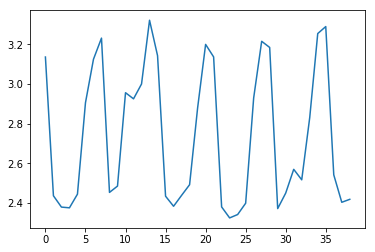

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.851851   
air_0164b9927d20bcc3_2017-04-23              1.414959   
air_0241aa3964b7f861_2017-04-23              2.375807   
air_0328696196e46f18_2017-04-23              2.139470   
air_034a3d5b40d5b1b1_2017-04-23              3.537001   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.371603  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.116316  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.759688  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.494938  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.363723

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l4_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')